In [15]:
import os

os.chdir('/opt/project')
print(os.getcwd())

/opt/project


# Registration

In [ ]:
import warnings
import pandas as pd
import os
import shutil

# for copying meningioma data from the original folder structure to one suitable with autorad

from multiprocessing import Pool


def process_patient(patient_info):
    patient_src, dest_patient_folder = patient_info
    expected_files = {'ADC.nii.gz', 'flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz', 'mask.nii.gz'}
    found_files = set()
    for file in os.listdir(patient_src):
        if file.endswith('.nii') or file.endswith('.gz'):
            if 'ADC' in file:
                new_filename = 'ADC.nii'
            elif 'flair' in file:
                new_filename = 'flair.nii.gz'
            elif 't1ce' in file:
                new_filename = 't1ce.nii.gz'
            elif 't1' in file:
                new_filename = 't1.nii.gz'
            elif 't2' in file:
                new_filename = 't2.nii.gz'
            elif '_1.nii' in file or '_2.nii' in file or '_3.nii' in file:
                new_filename = 'mask.nii.gz'
            else:
                warnings.warn(f"Unexpected file {file} in patient folder {patient_src}")
                continue

            src_file_path = os.path.join(patient_src, file)
            dest_file_path = os.path.join(dest_patient_folder, new_filename)
            shutil.copy(src_file_path, dest_file_path)
            print(f"Copied file {src_file_path} to {dest_file_path}")

            found_files.add(new_filename)

    if expected_files != found_files:
        missing_files = expected_files - found_files
        warnings.warn(f"Missing files {missing_files} in patient folder {patient_src}")

    return dest_patient_folder


def copy_patient_data(src_dir, dest_dir, n_cpu=2):
    """
    Copies patient data from the source directory to the destination directory
    while maintaining an ascending pattern of integer-based patient IDs. The function
    creates a mapping of patient IDs, grades, and their original data paths,
    and saves the mapping to a CSV file. It also renames the files as per the required format.

    Parameters:
        src_dir (str): The path to the source directory containing patient data organized by grades.
        dest_dir (str): The path to the destination directory where the copied patient data will be stored.

    Returns:
        None: The function performs the copy operation, file renaming, and saves the mapping to a CSV file.

    Raises:
        FileNotFoundError: If any of the expected files are missing.
        ValueError: If there are additional files that don't match the pattern.
    """
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
    patient_data = []
    patient_info_list = []
    for grade_folder in os.listdir(src_dir):
        grade_path = os.path.join(src_dir, grade_folder)
        if os.path.isdir(grade_path):
            for patient_folder in os.listdir(grade_path):
                patient_src = os.path.join(grade_path, patient_folder)
                if os.path.isdir(patient_src):
                    dest_patient_id = len(os.listdir(dest_dir)) + 1
                    dest_patient_folder = os.path.join(dest_dir, f"ID_{dest_patient_id}")
                    os.makedirs(dest_patient_folder, exist_ok=True)
                    patient_info_list.append((patient_src, dest_patient_folder))
                    grade = 1 if grade_folder == 'Grade1Data' else 2
                    patient_data.append((f"ID_{dest_patient_id}", grade, patient_src))

    # Process patient data in parallel using multiprocessing
    with Pool(n_cpu) as pool:
        dest_patient_folders = pool.map(process_patient, patient_info_list)

    # Create a pandas DataFrame from the patient_data list
    df = pd.DataFrame(patient_data, columns=["Patient_ID", "Grade", "Original_Data_Path"])

    # Save the DataFrame to a CSV file
    df.to_csv("patient_grade_mapping.csv", index=False)


copy_patient_data('./data/meningioma', './data/meningioma_data')

In [ ]:
from src.preprocessing.registration import register_patients

register_patients(data_dir='./data', 
                  static_stem='t1ce.nii.gz',
                    moving_stem='ADC.nii', 
                    utput_stem='registered_adc.nii.gz', 
                    transform_method='rigid')

# Test Autoencoder Performance

In [ ]:
def plot_debug(stk_image):
    plt.figure()
    plt.imshow(sitk.GetArrayFromImage(stk_image)[5, :, :], cmap='gray')
    plt.show()


def plot_slices(output_tensor, slice_index, num_samples=5, original_tensor=None,
                title=None, save_dir=None):
    """
    Plot a slice from each image modality of the output tensor for a specified number of samples.

    Parameters:
        output_tensor (torch.Tensor): The output tensor from the autoencoder.
        slice_index (int): The index of the slice to be plotted.
        image_modalities (list): List of image modality names.
        num_samples (int): The number of samples to plot.
        title_prefix (str): Prefix to add to the plot titles.

    Returns:
        None
    """
    batch_size, num_modalities, length, width, height = output_tensor.shape

    for sample_idx in range(min(num_samples, batch_size)):
        plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

        for modality_idx in range(num_modalities):
            plt.subplot(2, num_modalities, modality_idx + 1)
            plt.imshow(output_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
            plt.title(f'generated Sample {sample_idx + 1}, {modality_idx}')
            plt.axis('off')

        if original_tensor is not None:
            for modality_idx in range(num_modalities):
                plt.subplot(2, num_modalities, num_modalities + modality_idx + 1)
                plt.imshow(original_tensor[sample_idx, modality_idx, slice_index, :, :], cmap='gray')
                plt.title(f'original Sample {sample_idx + 1}, {modality_idx}')
                plt.axis('off')

        if title is not None:
            plt.suptitle(title)
        if save_dir is not None:
            plt.savefig(f'{save_dir}_{sample_idx}.png')

        plt.show()                                    

In [ ]:
from torchio import SubjectsDataset
from src.dataset import TransformingDataLoader, SkorchSubjectsDataset
from skorch.callbacks import EarlyStopping, GradientNormClipping
from src.models.autoencoder import SegResNetVAE2, BetaVAELoss, Encoder
from src.pipeline.pipeline_components import get_multimodal_feature_dataset, split_feature_dataset
import torchio as tio
from datetime import datetime
import torch


# setup dataset, extract features, split the data
feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

id_list = feature_dataset.X['ID'].to_numpy()

dataset_train_transform = tio.Compose([tio.Resample((1, 1, 1)),
                                                    tio.ToCanonical(),
                                                    tio.Mask(masking_method='mask', outside_value=0),
                                                    tio.CropOrPad(target_shape=(96, 96, 96), mask_name='mask'),
                                                    tio.ZNormalization(masking_method='mask')])

encoder = Encoder(SegResNetVAE2,
                    module__input_image_size=[96, 96, 96],
                    module__spatial_dims=3,
                    module__in_channels=5,
                    module__out_channels=5,
                    module__dropout_prob=0.2,
                    module__init_filters=32,
                    batch_size=10,
                    # output_format='pandas',
                    criterion=BetaVAELoss,
                    max_epochs=200,
                    callbacks=[EarlyStopping(load_best=True),
                               GradientNormClipping(1),
                               ],
                    optimizer=torch.optim.AdamW,
                    batch_size=4,
                    lr=0.001,
                    iterator_train=TransformingDataLoader,
                    iterator_train__augment_transforms=tio.Compose([tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                                                    tio.RandomAffine(p=0.5, label_keys='mask',
                                                                                     scales=0.1, degrees=0,
                                                                                     translation=0, isotropic=True),
                                                                    tio.RandomFlip(flip_probability=0.5,
                                                                                   label_keys='mask', axes=(0, 1, 2))
                                                                    ]),
                    iterator_train__num_workers=20,
                    iterator_train__shuffle=True,
                    iterator_valid__num_workers=4,
                    dataset=SkorchSubjectsDataset,
                    dataset__transform=dataset_train_transform,
                    criterion__kld_weight=0.1,
                    device='cuda'
                    )

encoder.fit(id_list)

generated_images = encoder.predict(id_list[:10])

subject_dataset = SubjectsDataset(id_list[:10], transform=dataset_train_transform)

original_images = torch.stack(
    [torch.concatenate([i.data for i in subject.get_images()]) for subject in subject_dataset])
plot_slices(generated_images, original_tensor=original_images, slice_index=48, num_samples=8, title=datetime.now().strftime(f"%Y%m%d%H%M%S"),
            save_dir=f'outputs/generated_images/{datetime.now().strftime(f"%Y%m%d%H%M%S")}')

# Find Optimal shape of Encoder to crop to

In [ ]:
from src.pipeline.pipeline_components import get_multimodal_feature_dataset
from src.dataset.skorch_subject_ds import SkorchSubjectsDataset
import torchio as tio
import numpy as np


feature_dataset = get_multimodal_feature_dataset(data_dir='./data/meningioma_data',
                                                 image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                                                 mask_stem='mask',
                                                 target_column='Grade',
                                                 label_csv_path='./data/meningioma_meta.csv',
                                                 extraction_params='./conf/radiomic_params/meningioma_mr.yaml',
                                                 feature_df_merger={
                                                     '_target_': 'src.pipeline.df_mergers.meningioma_df_merger'},
                                                 n_jobs=6,
                                                 existing_feature_df='tests/meningioma_feature_dataset.csv',
                                                 additional_features=['ID']
                                                 )

ds = SkorchSubjectsDataset(feature_dataset.X.ID, None, data_dir='./data/meningioma_data',
                           image_stems=('registered_adc', 't2', 'flair', 't1', 't1ce'),
                           mask_stem='mask',
                           transform=tio.Compose([tio.Resample(target=1),tio.ToCanonical(),tio.CropOrPad(target_shape=None, mask_name='mask')]))

shapes = [ds[i][0].shape for i in range(len(ds))]

np_shapes = np.concatenate(shapes)

np.unique(np_shapes, return_counts=True)

# Explainer

In [9]:
import mlflow
from autorad.models.classifier import MLClassifier
from autorad.inference import infer_utils
import shap

model1_run_id = '02051a270a864157837f476950ef3023'
model2_run_id = '60e74372c5844fd0aa28bddefc58acd9'


def get_shap_values(run_id, existing_feature_df=None, existing_splits=None):
    run = mlflow.get_run(run_id)
    artifact_uri = run.info.artifact_uri

    model = MLClassifier.load_from_mlflow(f"{artifact_uri}/model")
    preprocessor = mlflow.sklearn.load_model(f"{artifact_uri}/preprocessor")

    dataset_artifacts = infer_utils.load_dataset_artifacts(run.to_dictionary()['info'])

    dataset_df = dataset_artifacts['df'] if existing_feature_df is None else existing_feature_df
    dataset_splits = dataset_artifacts['splits'] if existing_splits is None else existing_splits

    feature_dataset = infer_utils.load_feature_dataset(feature_df=dataset_df,
                                           dataset_config=dataset_artifacts['dataset_config'],
                                           splits=dataset_splits)

    if hasattr(preprocessor.pipeline.steps[-1][1], 'fit_resample'):
        preprocessed_X, y = preprocessor.pipeline.fit_resample(feature_dataset.X, feature_dataset.y)
    else:
        preprocessed_X, y = preprocessor.pipeline.fit_transform(feature_dataset.X, feature_dataset.y)

    model.fit(preprocessed_X, y)

    explainer = shap.Explainer(model.predict_proba_binary, preprocessed_X)
    shap_values = explainer(preprocessed_X, max_evals=2 * len(feature_dataset.df.columns) + 1)

    # return shap.plots.waterfall(shap_values[0], max_display=max_display, show=show)
    return shap_values, dataset_df, dataset_splits




In [10]:
model1_shap_values, dataset_df, dataset_splits = get_shap_values(model1_run_id)
model2_shap_values, _, _ = get_shap_values(model2_run_id, dataset_df, dataset_splits)

PermutationExplainer explainer: 195it [39:47, 12.31s/it]                                                                                                                        


0.3259993136418676
0.2048761193323976
0.07596617269201066
0.08331702384919158
0.019960244503841953
0.06191835885043688


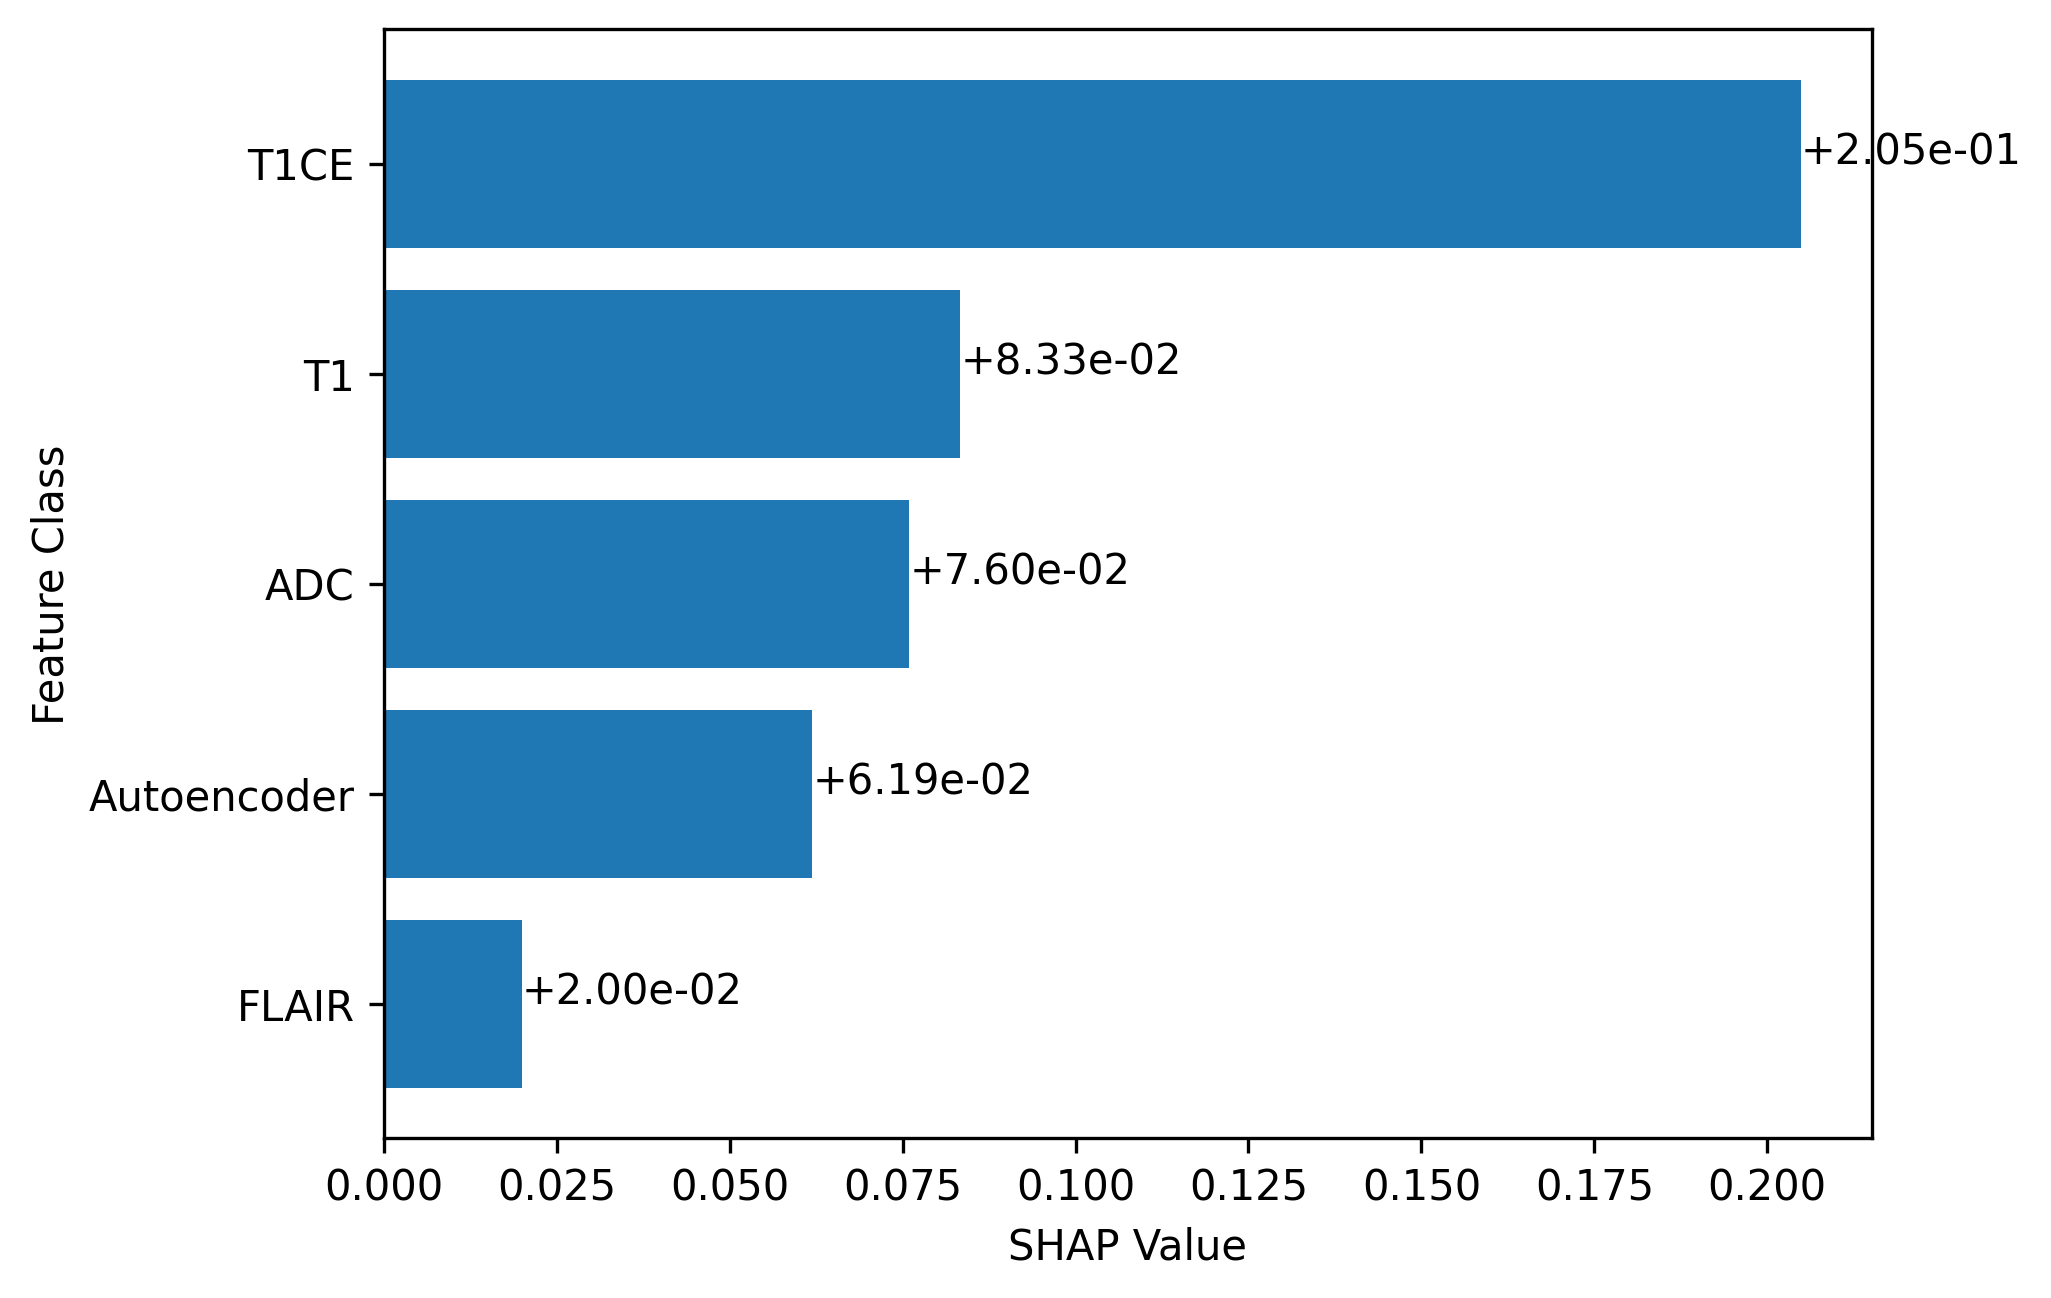

0.800179029857577
0.43108112467357407
0.16661856766505723
0.35025731368688395
0.2708732386576255
0.0


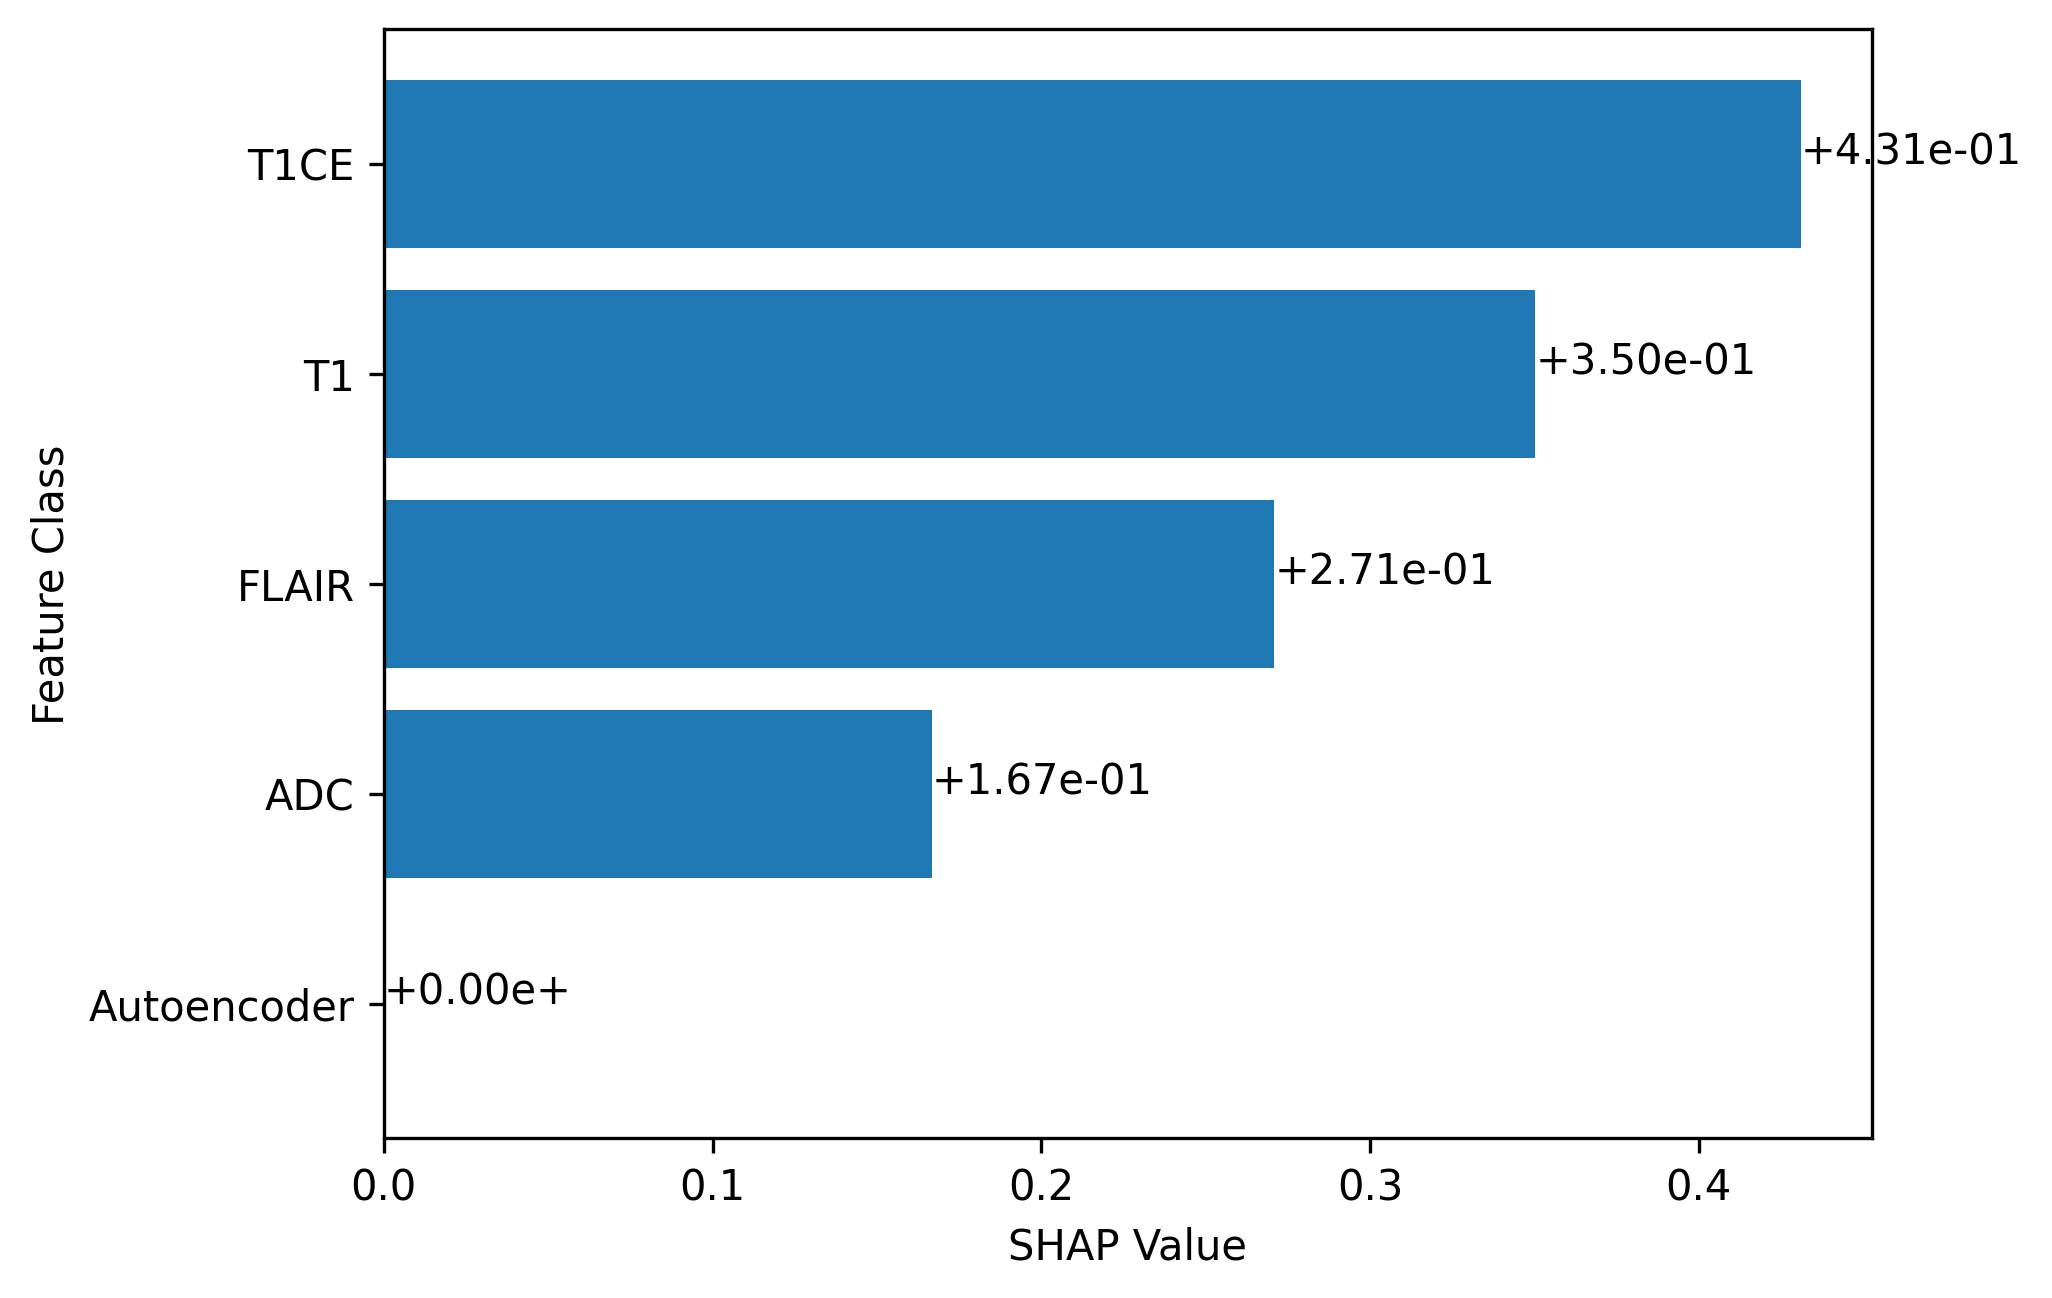

In [213]:
import matplotlib.pyplot as plt


def shap_bar_per_category(shap_values, categories=[], labels=None):
    if labels is not None:
        assert len(labels) == len(categories)

    mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
    test_shap_values = pd.Series({shap_values.feature_names[i]: mean_shap_values[i] for i in range(len(shap_values.feature_names))})

    category_values = {}
    for i,category in enumerate(categories):
        if labels is not None:
            label = labels[i]
        else:
            label = category
        category_values[label] = test_shap_values.filter(regex=category).sum()
    
    sorted_data = sorted(category_values.items(), key=lambda x: x[1])
    x = [cat[0] for cat in sorted_data]
    y = [cat[1] for cat in sorted_data]

    fig, ax = plt.subplots(dpi=300)
    ax.barh(x, y)
    
    for index, value in enumerate(y):
        plt.text(value, index, format_value(value, '%+.2e'))
    
    plt.xlabel('SHAP Value')
    plt.ylabel('Feature Class')
    plt.show()

    


shap_bar_per_category(model1_shap_values, 
                      ['t1', 't1ce', 'registered_adc', 't2', 'flair', 'SegResNet'],
                      ['T1', 'T1CE', 'ADC', 'T1', 'FLAIR', 'Autoencoder'])

shap_bar_per_category(model2_shap_values, 
                      ['t1', 't1ce', 'registered_adc', 't2', 'flair'],
                      ['T1', 'T1CE', 'ADC', 'T1', 'FLAIR'])





Custom shap plot function to display the shap values as scientific values

In [5]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy

from shap import Cohorts, Explanation
from shap.utils import format_value, ordinal_str
from shap.utils._exceptions import DimensionError
from shap.plots import colors
from shap.plots._labels import labels
from shap.plots._utils import (
    convert_ordering,
    dendrogram_coords,
    get_sort_order,
    merge_nodes,
    sort_inds,
)

def bar(shap_values, max_display=10, order=Explanation.abs, clustering=None, clustering_cutoff=0.5,
        merge_cohorts=False, show_data="auto", show=True):
    """Create a bar plot of a set of SHAP values.

    If a single sample is passed, then we plot the SHAP values as a bar chart. If an
    :class:`.Explanation` with many samples is passed, then we plot the mean absolute
    value for each feature column as a bar chart.


    Parameters
    ----------
    shap_values : shap.Explanation or shap.Cohorts or dictionary of shap.Explanation objects
        A single row of a SHAP :class:`.Explanation` object (i.e. ``shap_values[0]``) or
        a multi-row Explanation object that we want to summarize.

    max_display : int
        How many top features to include in the bar plot (default is 10).

    show : bool
        Whether ``matplotlib.pyplot.show()`` is called before returning.
        Setting this to ``False`` allows the plot
        to be customized further after it has been created.

    Examples
    --------

    See `bar plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html>`_.

    """

    # assert str(type(shap_values)).endswith("Explanation'>"), "The shap_values parameter must be a shap.Explanation object!"

    # convert Explanation objects to dictionaries
    if isinstance(shap_values, Explanation):
        cohorts = {"": shap_values}
    elif isinstance(shap_values, Cohorts):
        cohorts = shap_values.cohorts
    elif isinstance(shap_values, dict):
        cohorts = shap_values
    else:
        emsg = (
            "The shap_values argument must be an Explanation object, Cohorts "
            "object, or dictionary of Explanation objects!"
        )
        raise TypeError(emsg)

    # unpack our list of Explanation objects we need to plot
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i, exp in enumerate(cohort_exps):
        if not isinstance(exp, Explanation):
            emsg = (
                "The shap_values argument must be an Explanation object, Cohorts "
                "object, or dictionary of Explanation objects!"
            )
            raise TypeError(emsg)

        if len(exp.shape) == 2:
            # collapse the Explanation arrays to be of shape (#features,)
            cohort_exps[i] = exp.abs.mean(0)
        if cohort_exps[i].shape != cohort_exps[0].shape:
            emsg = (
                "When passing several Explanation objects, they must all have "
                "the same number of feature columns!"
            )
            raise DimensionError(emsg)
        # TODO: check other attributes for equality? like feature names perhaps? probably clustering as well.

    # unpack the Explanation object
    features = cohort_exps[0].display_data if cohort_exps[0].display_data is not None else cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    if clustering is None:
        partition_tree = getattr(cohort_exps[0], "clustering", None)
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering
    if partition_tree is not None:
        assert partition_tree.shape[1] == 4, "The clustering provided by the Explanation object does not seem to be a partition tree (which is all shap.plots.bar supports)!"
    op_history = cohort_exps[0].op_history
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])

    if len(values[0]) == 0:
        raise Exception("The passed Explanation is empty! (so there is nothing to plot)")

    # we show the data on auto only when there are no transforms
    if show_data == "auto":
        show_data = len(op_history) == 0

    # TODO: Rather than just show the "1st token", "2nd token", etc. it would be better to show the "Instance 0's 1st but", etc
    if issubclass(type(feature_names), str):
        feature_names = [ordinal_str(i)+" "+feature_names for i in range(len(values[0]))]

    # build our auto xlabel based on the transform history of the Explanation object
    xlabel = "SHAP value"
    for op in op_history:
        if op["name"] == "abs":
            xlabel = "|"+xlabel+"|"
        elif op["name"] == "__getitem__":
            pass # no need for slicing to effect our label, it will be used later to find the sizes of cohorts
        else:
            xlabel = str(op["name"])+"("+xlabel+")"

    # find how many instances are in each cohort (if they were created from an Explanation object)
    cohort_sizes = []
    for exp in cohort_exps:
        for op in exp.op_history:
            if op.get("collapsed_instances", False): # see if this if the first op to collapse the instances
                cohort_sizes.append(op["prev_shape"][0])
                break


    # unwrap any pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # ensure we at least have default feature names
    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(values[0]))])

    # determine how many top features we will plot
    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(values[0]))
    max_display = min(max_display, num_features)

    # iteratively merge nodes until we can cut off the smallest feature values to stay within
    # num_features without breaking a cluster tree
    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()
    while True:
        feature_order = np.argsort(np.mean([np.argsort(convert_ordering(order, Explanation(values[i]))) for i in range(values.shape[0])], 0))
        if partition_tree is not None:

            # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
            clust_order = sort_inds(partition_tree, np.abs(values).mean(0))

            # now relax the requirement to match the partition tree ordering for connections above clustering_cutoff
            dist = scipy.spatial.distance.squareform(scipy.cluster.hierarchy.cophenet(partition_tree))
            feature_order = get_sort_order(dist, clust_order, clustering_cutoff, feature_order)

            # if the last feature we can display is connected in a tree the next feature then we can't just cut
            # off the feature ordering, so we need to merge some tree nodes and then try again.
            if max_display < len(feature_order) and dist[feature_order[max_display-1],feature_order[max_display-2]] <= clustering_cutoff:
                #values, partition_tree, orig_inds = merge_nodes(values, partition_tree, orig_inds)
                partition_tree, ind1, ind2 = merge_nodes(np.abs(values).mean(0), partition_tree)
                for i in range(len(values)):
                    values[:,ind1] += values[:,ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    # here we build our feature names, accounting for the fact that some features might be merged together
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    feature_names_new = []
    for pos,inds in enumerate(orig_inds):
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        else:
            full_print = " + ".join([feature_names[i] for i in inds])
            if len(full_print) <= 40:
                feature_names_new.append(full_print)
            else:
                max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
                feature_names_new.append(feature_names[inds[max_ind]] + " + %d other features" % (len(inds)-1))
    feature_names = feature_names_new

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features-1, len(values[0]))])
        values[:,feature_order[num_features-1]] = np.sum([values[:,feature_order[i]] for i in range(num_features-1, len(values[0]))], 0)

    # build our y-tick labels
    yticklabels = []
    for i in feature_inds:
        if features is not None and show_data:
            yticklabels.append(format_value(features[i], "%0.03f") + " = " + feature_names[i])
        else:
            yticklabels.append(feature_names[i])
    if num_features < len(values[0]):
        yticklabels[-1] = "Sum of %d other features" % num_cut

    # compute our figure size based on how many features we are showing
    row_height = 0.5
    pl.gcf().set_size_inches(8, num_features * row_height * np.sqrt(len(values)) + 1.5)

    # if negative values are present then we draw a vertical line to mark 0, otherwise the axis does this for us...
    negative_values_present = np.sum(values[:,feature_order[:num_features]] < 0) > 0
    if negative_values_present:
        pl.axvline(0, 0, 1, color="#000000", linestyle="-", linewidth=1, zorder=1)

    # draw the bars
    patterns = (None, '\\\\', '++', 'xx', '////', '*', 'o', 'O', '.', '-')
    total_width = 0.7
    bar_width = total_width / len(values)
    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        pl.barh(
            y_pos + ypos_offset, values[i,feature_inds],
            bar_width, align='center',
            color=[colors.blue_rgb if values[i,feature_inds[j]] <= 0 else colors.red_rgb for j in range(len(y_pos))],
            hatch=patterns[i], edgecolor=(1,1,1,0.8), label=f"{cohort_labels[i]} [{cohort_sizes[i] if i < len(cohort_sizes) else None}]"
        )

    # draw the yticks (the 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks)
    pl.yticks(list(y_pos) + list(y_pos + 1e-8), yticklabels + [t.split('=')[-1] for t in yticklabels], fontsize=13)

    xlen = pl.xlim()[1] - pl.xlim()[0]
    fig = pl.gcf()
    ax = pl.gca()
    #xticks = ax.get_xticks()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen/width

    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        for j in range(len(y_pos)):
            ind = feature_order[j]
            if values[i,ind] < 0:
                pl.text(
                    values[i,ind] - (5/72)*bbox_to_xscale, y_pos[j] + ypos_offset, format_value(values[i,ind], '%+.2e'),
                    horizontalalignment='right', verticalalignment='center', color=colors.blue_rgb,
                    fontsize=12
                )
            else:
                pl.text(
                    values[i,ind] + (5/72)*bbox_to_xscale, y_pos[j] + ypos_offset, format_value(values[i,ind], '%+.2e'),
                    horizontalalignment='left', verticalalignment='center', color=colors.red_rgb,
                    fontsize=12
                )

    # put horizontal lines for each feature row
    for i in range(num_features):
        pl.axhline(i+1, color="#888888", lw=0.5, dashes=(1, 5), zorder=-1)

    if features is not None:
        features = list(features)

        # try and round off any trailing zeros after the decimal point in the feature values
        for i in range(len(features)):
            try:
                if round(features[i]) == features[i]:
                    features[i] = int(features[i])
            except Exception:
                pass # features[i] must not be a number

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    if negative_values_present:
        pl.gca().spines['left'].set_visible(False)
    pl.gca().tick_params('x', labelsize=11)

    xmin,xmax = pl.gca().get_xlim()
    ymin,ymax = pl.gca().get_ylim()

    if negative_values_present:
        pl.gca().set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax-xmin)*0.05)
    else:
        pl.gca().set_xlim(xmin, xmax + (xmax-xmin)*0.05)

    # if features is None:
    #     pl.xlabel(labels["GLOBAL_VALUE"], fontsize=13)
    # else:
    pl.xlabel(xlabel, fontsize=13)

    if len(values) > 1:
        pl.legend(fontsize=12)

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = pl.gca().yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")

    # draw a dendrogram if we are given a partition tree
    if partition_tree is not None:

        # compute the dendrogram line positions based on our current feature order
        feature_pos = np.argsort(feature_order)
        ylines,xlines = dendrogram_coords(feature_pos, partition_tree)

        # plot the distance cut line above which we don't show tree edges
        xmin,xmax = pl.xlim()
        xlines_min,xlines_max = np.min(xlines),np.max(xlines)
        ct_line_pos = (clustering_cutoff / (xlines_max - xlines_min)) * 0.1 * (xmax - xmin) + xmax
        pl.text(
            ct_line_pos + 0.005 * (xmax - xmin), (ymax - ymin)/2, "Clustering cutoff = " + format_value(clustering_cutoff, '%0.02f'),
            horizontalalignment='left', verticalalignment='center', color="#999999",
            fontsize=12, rotation=-90
        )
        line = pl.axvline(ct_line_pos, color="#dddddd", dashes=(1, 1))
        line.set_clip_on(False)

        for (xline, yline) in zip(xlines, ylines):

            # normalize the x values to fall between 0 and 1
            xv = (np.array(xline) / (xlines_max - xlines_min))

            # only draw if we are not going past distance threshold
            if np.array(xline).max() <= clustering_cutoff:

                # only draw if we are not going past the bottom of the plot
                if yline.max() < max_display:
                    lines = pl.plot(
                        xv * 0.1 * (xmax - xmin) + xmax,
                        max_display - np.array(yline),
                        color="#999999"
                    )
                    for line in lines:
                        line.set_clip_on(False)

    if show:
        pl.show()


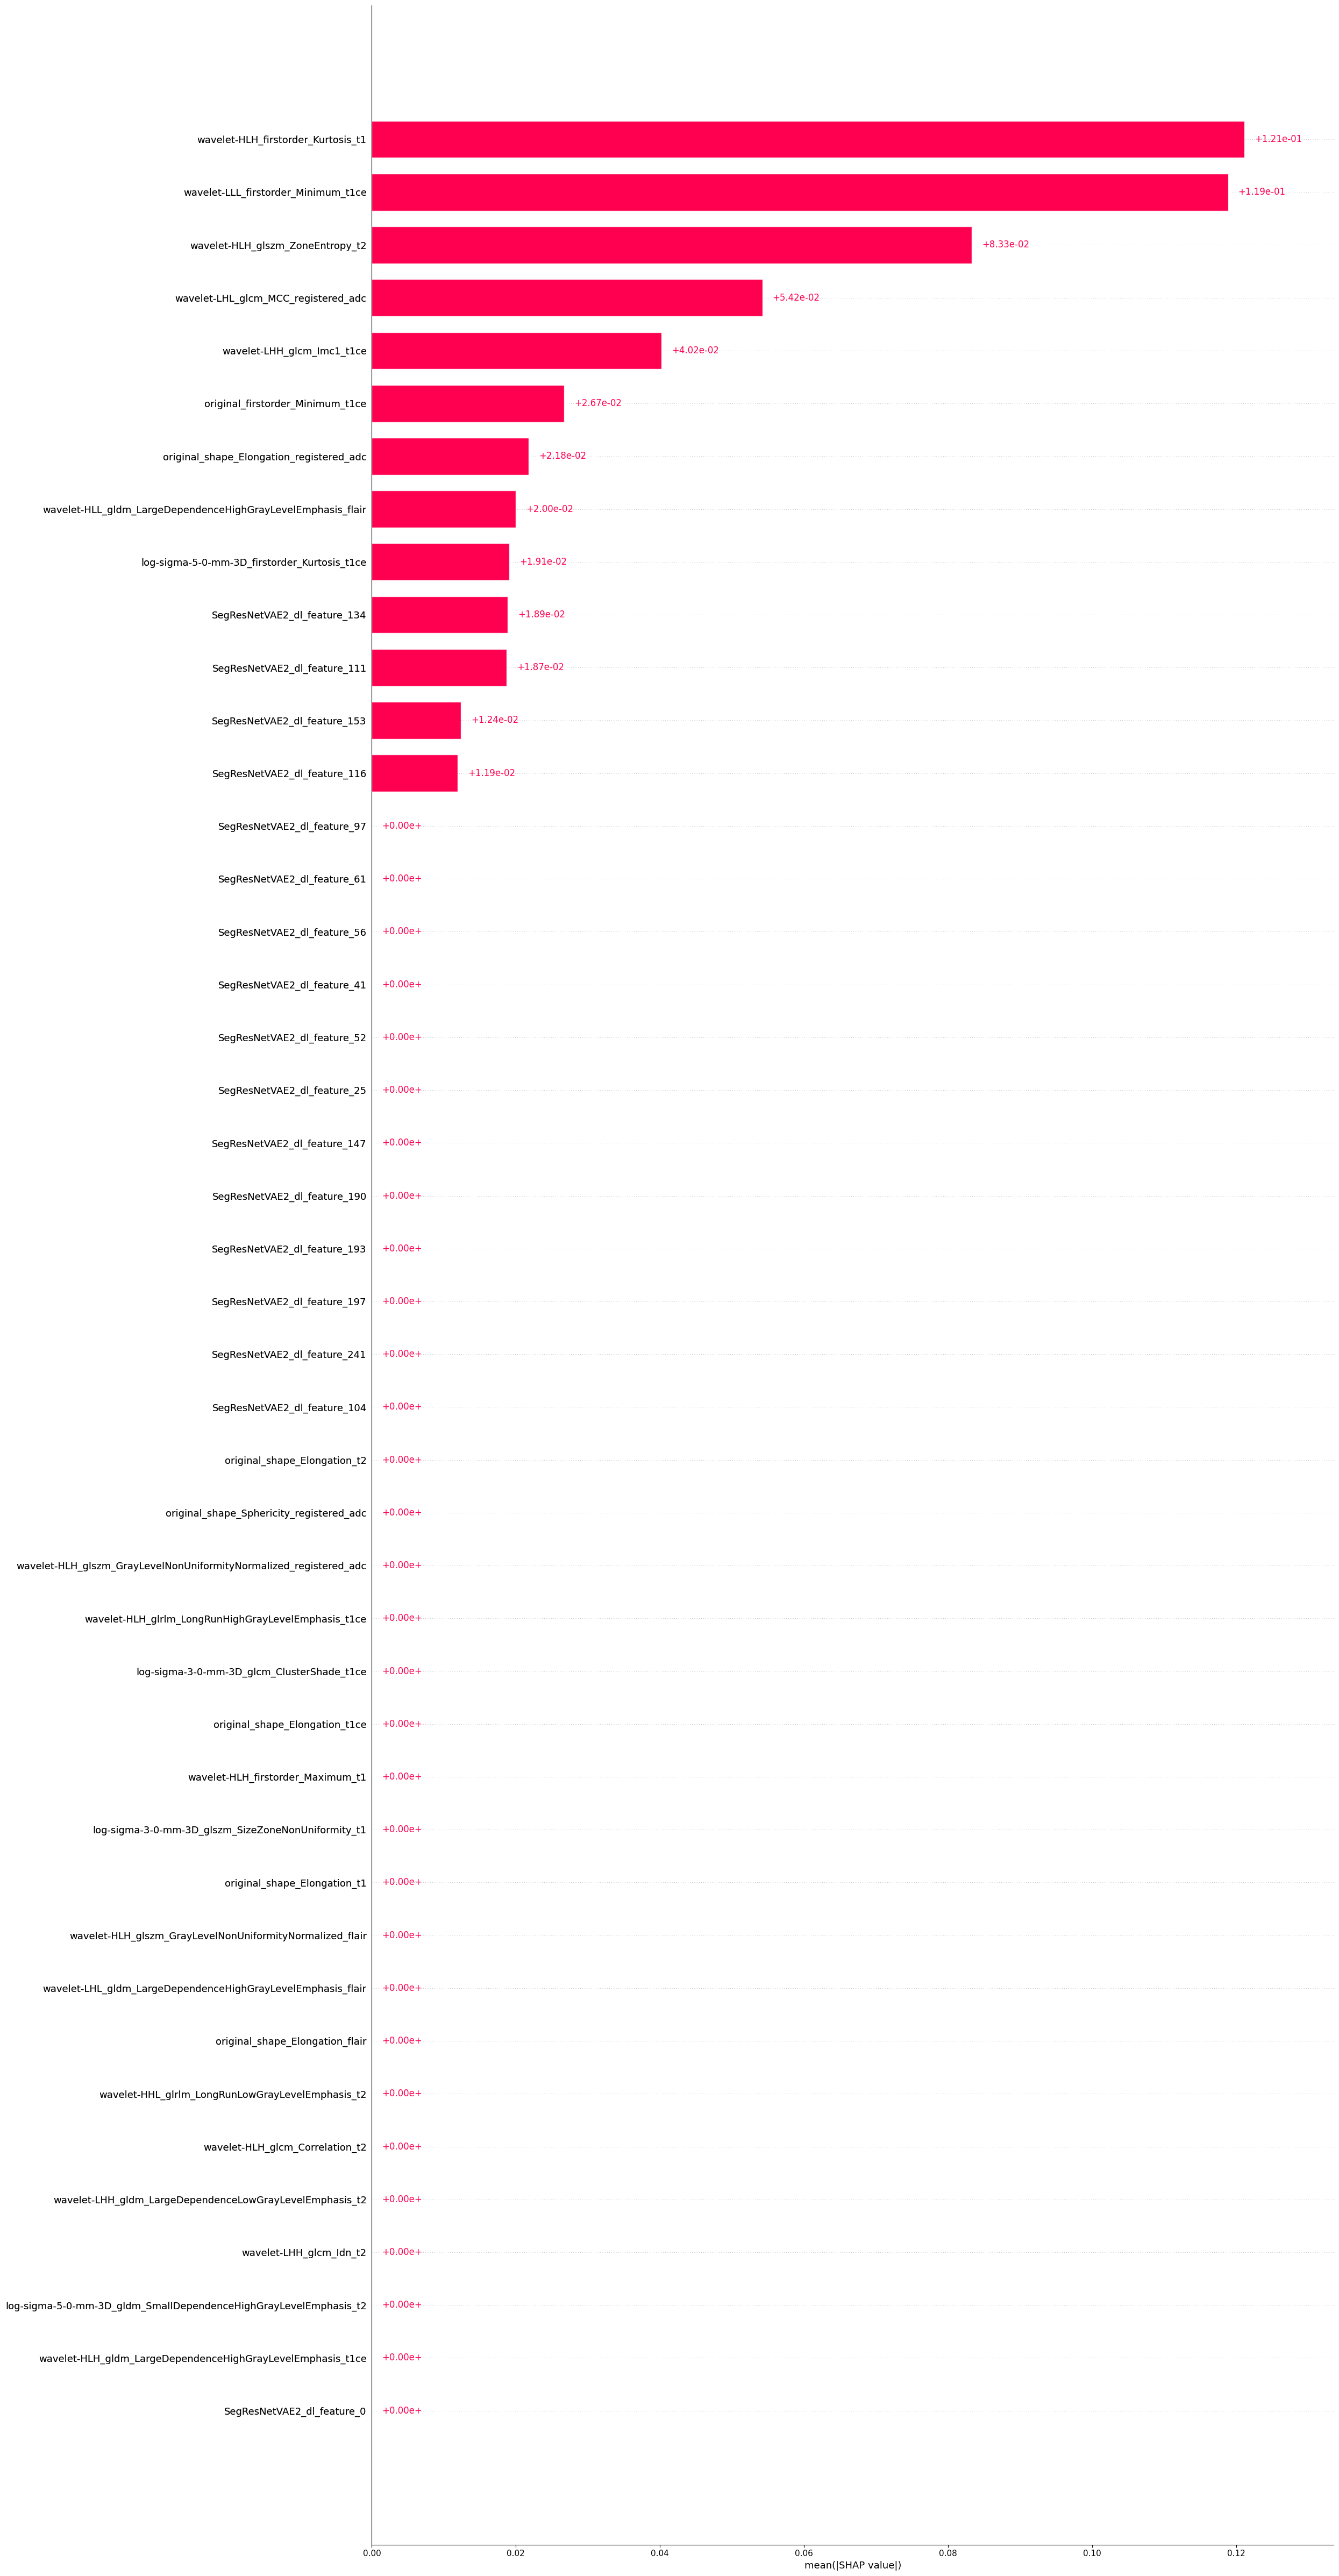

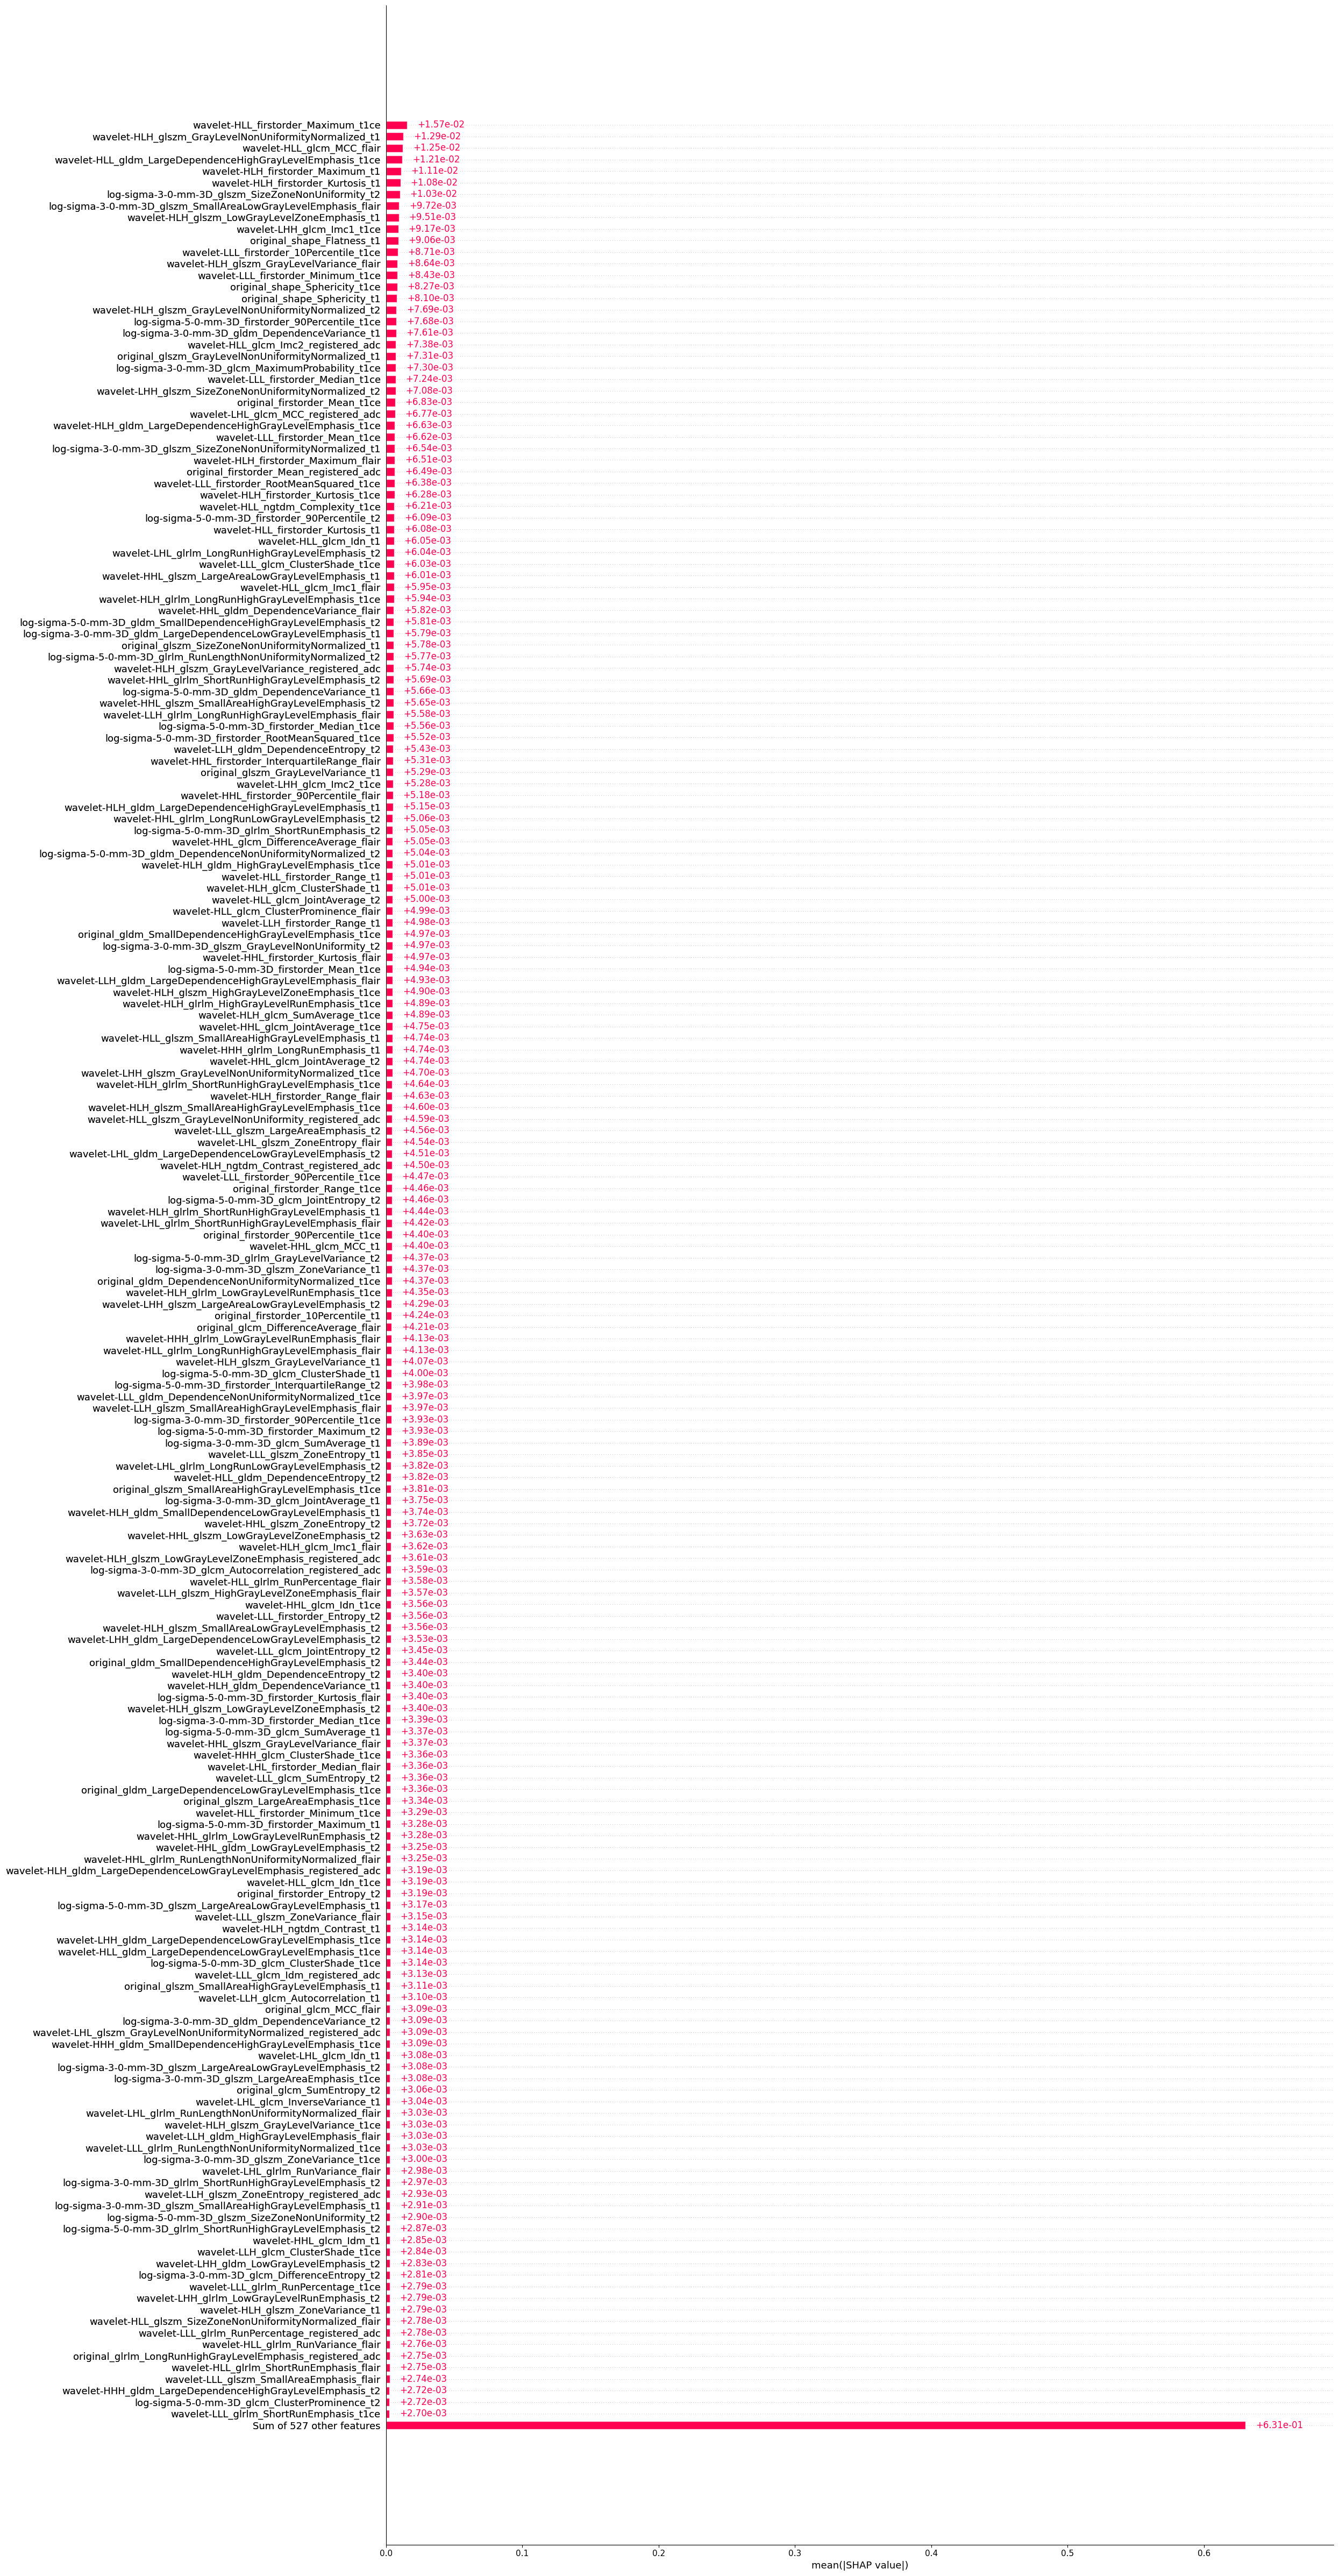

In [11]:
import os

def plot_shap_bar(shap_values, max_display=10, save_dir=None, size=None):
    ax = bar(shap_values, max_display=max_display, show=False)
    fig = pl.gcf()

    if size is not None:
        fig.set_size_inches(size, forward=True)
    fig.tight_layout()

    if save_dir is None:
        pl.show()
        return fig, ax
    
    fig.savefig(os.path.join(save_dir, 'shap_bar_plot.png'), dpi=300)
    return fig, ax


model1_output_dir = 'outputs/meningioma+autoencoder/2024-01-06-01-06-13'
model2_output_dir = 'outputs/meningioma/2024-01-06-00-08-33'

max_display=200

plot_shap_bar(model1_shap_values, max_display=max_display, save_dir=model1_output_dir, size=(25,48))
pl.show()
plot_shap_bar(model2_shap_values, max_display=max_display, save_dir=model2_output_dir, size=(25,48))
pl.show()


# Calibration Curve

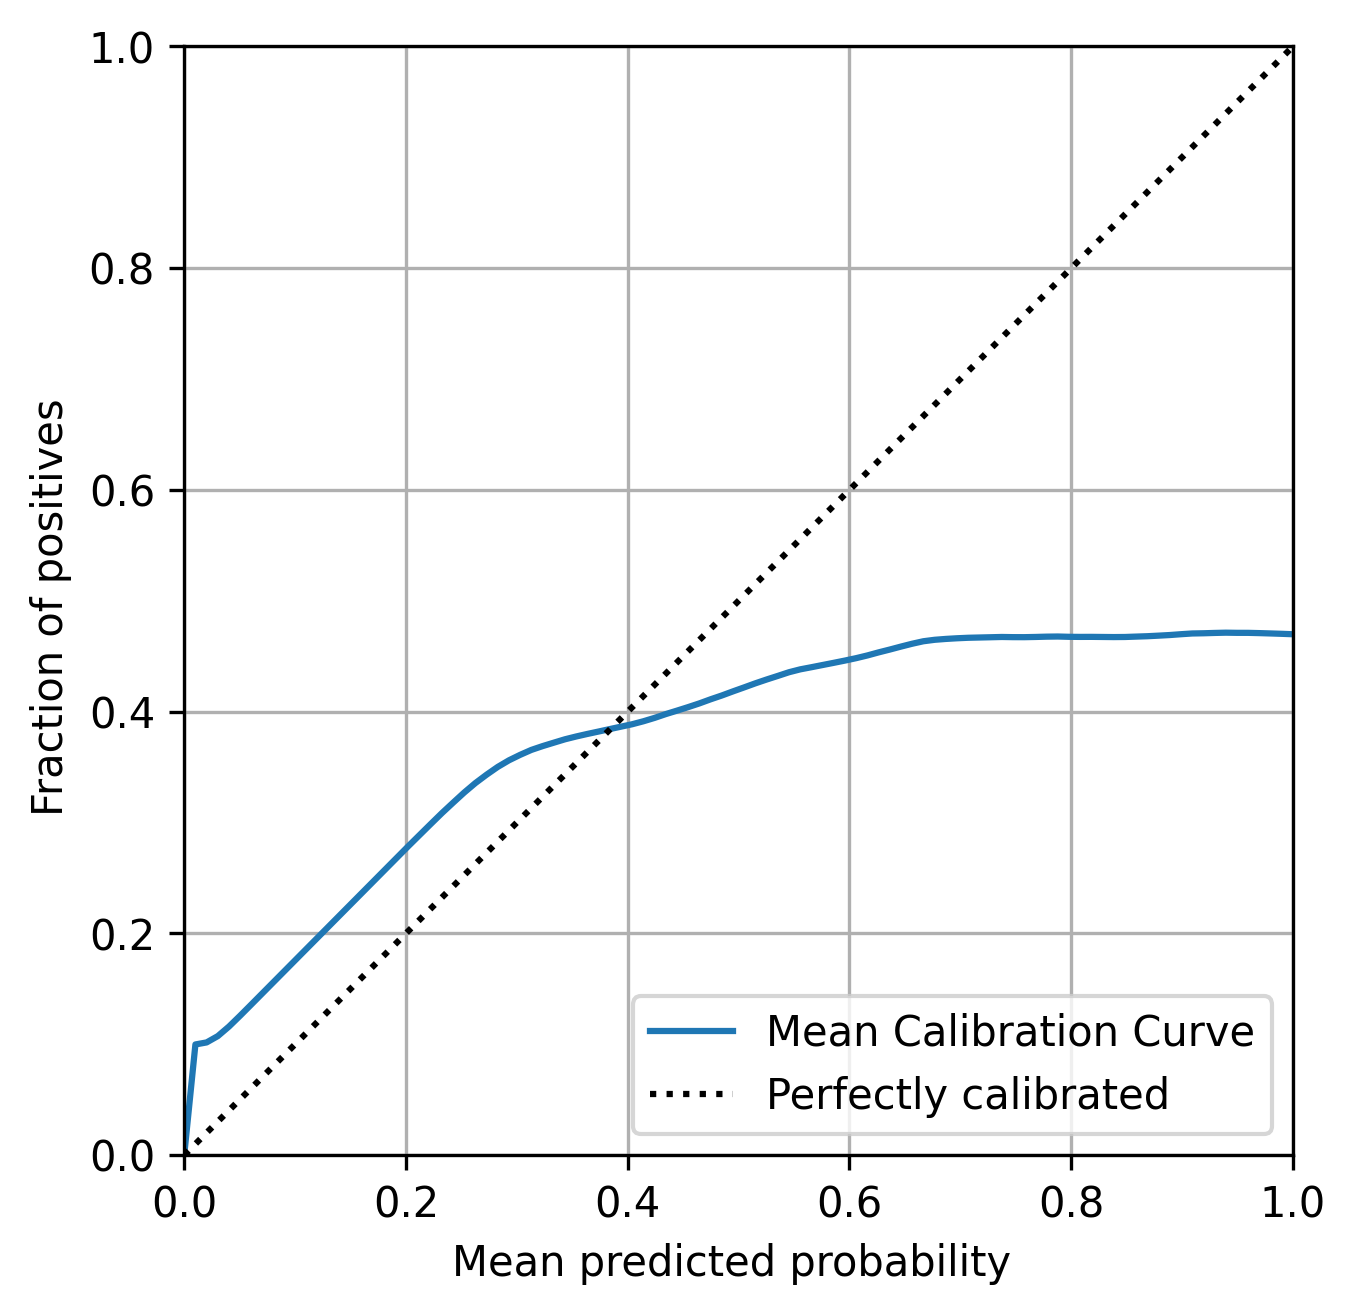

In [198]:
import pickle
from sklearn.calibration import CalibrationDisplay, calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve_with_ci(run_id, pos_label=1):
    run = mlflow.get_run(run_id)
    artifact_uri = run.info.artifact_uri
    with open(f'{artifact_uri.removeprefix("file://")}/bootstrap_scores.pkl','rb') as f:
        y_true_y_preds = [row[2] for row in pickle.load(f)]
    
    # CalibrationDisplay.from_predictions(y_true_y_preds[0][0], y_true_y_preds[0][1])
    # CalibrationDisplay.from_predictions(y_true_y_preds[1][0], y_true_y_preds[1][1], ax=disp.ax_)

    # for i in range(len(y_true_y_preds)):
    #     prob_true, prob_pred = calibration_curve(y_true_y_preds[i][0], y_true_y_preds[i][1])
    #     ax.plot(prob_pred, prob_true)

    mean_prob_pred = np.linspace(0,1,100)
    mean_prob_true = np.zeros_like(mean_prob_pred)

    interp_prob_true_list = []
    for i in range(len(y_true_y_preds)):
        prob_true, prob_pred = calibration_curve(y_true_y_preds[i][0], y_true_y_preds[i][1])
        interp_prob_true = np.interp(mean_prob_pred, prob_pred, prob_true)
        interp_prob_true[0] = 0.0
        mean_prob_true += interp_prob_true
        interp_prob_true_list.append(interp_prob_true)
        # prob_true_upper.append(interp_prob_true + 2 *)
    interp_prob_true_list = np.array(interp_prob_true_list)

    mean_prob_true /= len(y_true_y_preds)

    fig, ax = plt.subplots(dpi=300)

    ax.plot(mean_prob_pred, mean_prob_true, label='Mean Calibration Curve')
    ax.axis('scaled')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    ax.plot([0,1],[0,1], "k:", label='Perfectly calibrated')
    ax.legend(loc="lower right")
    ax.set(xlabel=f"Mean predicted probability {pos_label}",
           ylabel=f"Fraction of positives {pos_label}")
    plt.grid(True)
    plt.show()

    


plot_calibration_curve_with_ci(model2_run_id, pos_label="")

# Other code:

In [13]:
from datetime import datetime

def find_time_difference(time1, time2, format='%Y-%m-%d %H:%M:%S,%f'):

    date1 = datetime.strptime(time1, format)
    date2 = datetime.strptime(time2, format)
    difference = date2-date1
    return difference

find_time_difference('2024-01-06 00:56:17,550', '2024-01-06 01:00:51,369')/500

datetime.timedelta(microseconds=547638)

In [ ]:
samples_sizes=[16,32,64,118]
confidence_intervals=[(0.5,0.6), (0.6, 0.7), (0.65, 0.75), (0.67, 0.8)]

def plot_confidence_intervals(sample_sizes, confidence_intervals, y_label='roc_auc', save_dir=None):
    """
    :param sample_sizes: list of numbers
    :param confidence_intervals: expects in list of tuples [(a,b),(c,d)...]
    :return:
    """
    starts, ends = zip(*confidence_intervals)
    plt.plot(sample_sizes, starts)
    plt.plot(sample_sizes, ends)
    plt.fill_between(sample_sizes, starts, ends, alpha=0.2)
    plt.xlabel('Sample Size')
    plt.ylabel(y_label)
    plt.grid(True)
    if save_dir is not None:
        plt.savefig(save_dir, dpi=300)
    plt.show()

# Generate Icons

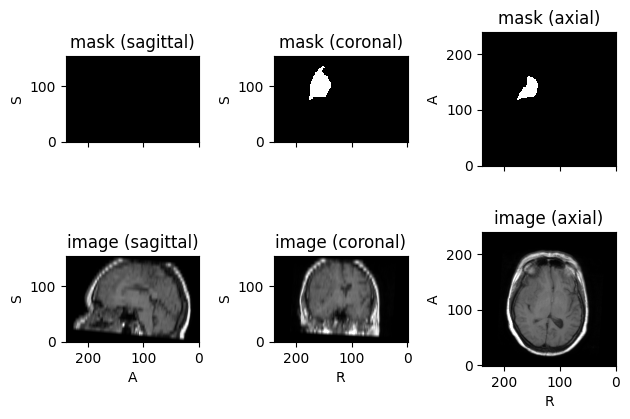

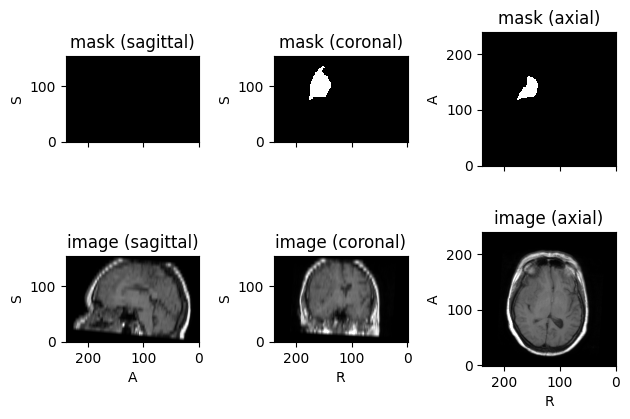

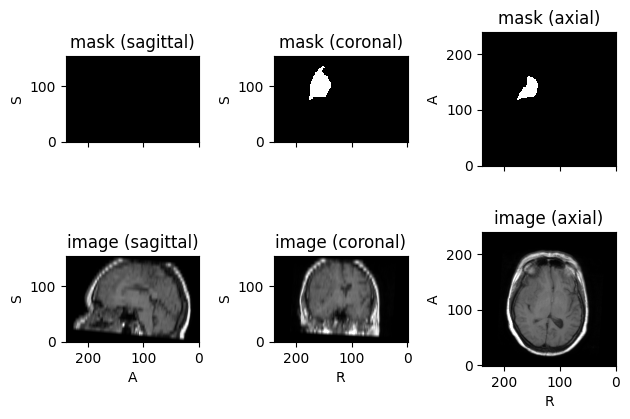

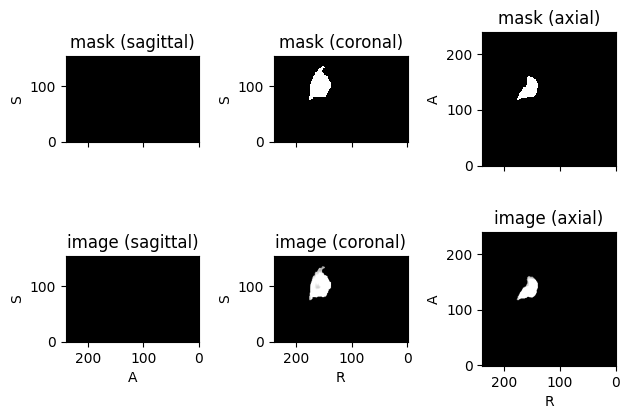

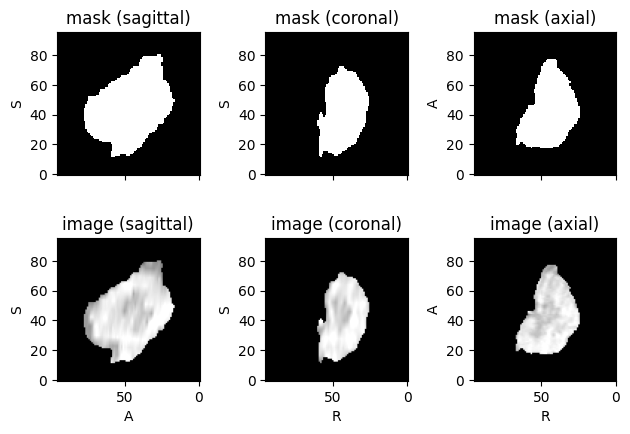

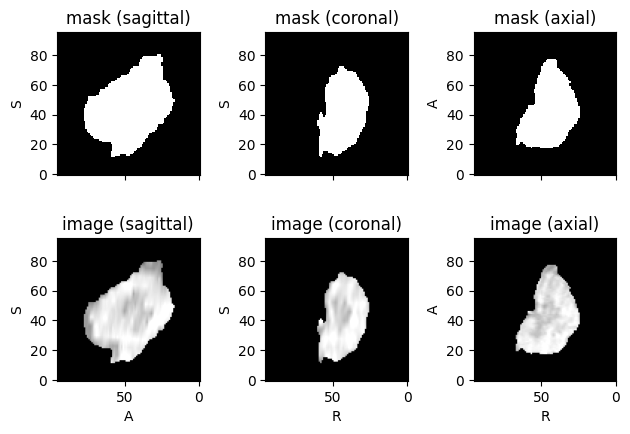

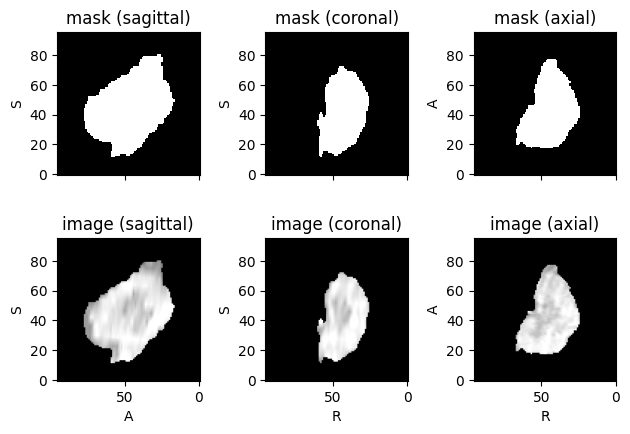

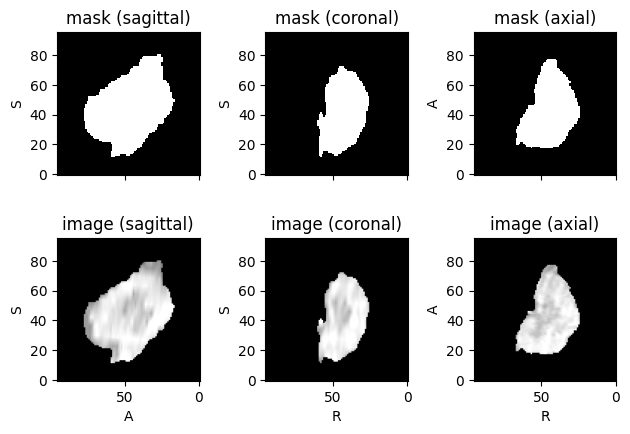

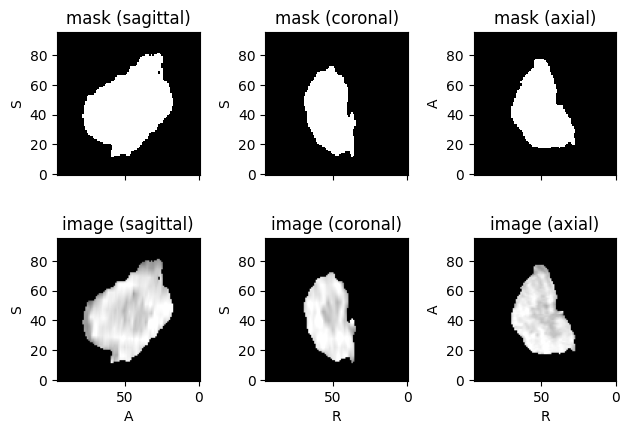

In [75]:
from src.pipeline.pipeline_components import get_data
from autorad.visualization import plot_volumes
import matplotlib.pyplot as plt
import torchio as tio

image_dataset = get_data('./data/meningioma_data', 't1', 'mask')


class Demonstrator:
    def __init__(self, image_dataset, n: int = 1, label:int=1):
        self.image_dataset = image_dataset
        self.case = image_dataset.df.iloc[n]
        self.label = label
    
    def plot_segmented(self):
        image_2D, mask_2D = self.get_2d_image()
        single_plot = plot_volumes.overlay_mask_contour(image_2D, mask_2D)
        fig, axs = plt.subplots(1, 1)
        axs.imshow(single_plot, cmap='gray')
        # axs.set_title(f"{case[image_dataset.ID_colname]}")
        axs.axis("off")
        plt.show()

    def plot_original(self):
        image_2D, mask_2D = self.get_2d_image()
        _, axs = plt.subplots(1,1)
        plt.imshow(image_2D, cmap='gray')
        axs.axis("off")

        plt.show()

    def get_2d_image(self):
        vols = plot_volumes.BaseVolumes.from_nifti(
        self.case[self.image_dataset.image_colname],
        self.case[self.image_dataset.mask_colname],
        window=None,
        label=self.label
        )
        image_2D, mask_2D = vols.get_slices()
        return image_2D, mask_2D

    def plot_transforms(self, transforms):
        tio_subject = tio.Subject(mask=tio.LabelMap(self.case[self.image_dataset.mask_colname]),
                                image=tio.ScalarImage(self.case[self.image_dataset.image_colname]))

        tio_subject.plot()
        for transform in transforms:
            tio_subject = transform(tio_subject)
            tio_subject.plot()


demonstrator = Demonstrator(image_dataset, 10)
# demonstrator.plot_segmented()
# demonstrator.plot_original()
demonstrator.plot_transforms([tio.Resample((1, 1, 1)),
                                tio.ToCanonical(),
                                tio.Mask(masking_method='mask', outside_value=0),
                                tio.CropOrPad(target_shape=(96, 96, 96), mask_name='mask'),
                                tio.ZNormalization(masking_method='mask'),
                                tio.RandomGamma(log_gamma=0.1, label_keys='mask'),
                                tio.RandomAffine(p=0.5, label_keys='mask',
                                                    scales=0.1, degrees=0,
                                                    translation=0, isotropic=True),
                                tio.RandomFlip(flip_probability=0.5,
                                                label_keys='mask', axes=(0, 1, 2))])

(26, 192, 192)


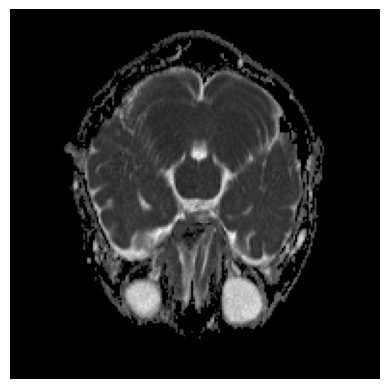

(155, 240, 240)


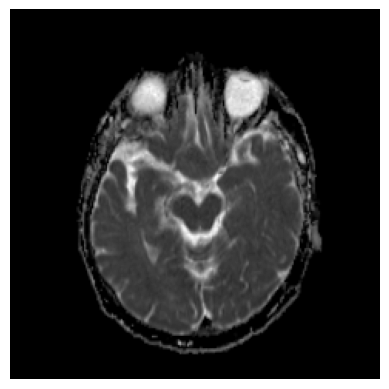

In [61]:
import SimpleITK as sitk

def plot_nifti(path, index):
    image = sitk.ReadImage(path)
    fig, ax = plt.subplots(1,1)
    print(sitk.GetArrayFromImage(image).shape)
    plt.imshow(sitk.GetArrayFromImage(image)[index,:,:], cmap="gray")
    ax.axis('off')
    plt.show()

plot_nifti('data/meningioma_data/ID_1/ADC.nii', 8)

plot_nifti('data/meningioma_data/ID_1/registered_adc.nii.gz', 60)